<a href="https://colab.research.google.com/github/Hhhdhfgvgbh/city/blob/master/up_m_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие задачи, описание

## Разработка алгоритма по прогнозированию карьерной траектории сотрудника

На основе метаданных работников необходимо разработать прогнозную модель, которая будет предсказывать, какой тип повышения получит сотрудник в будущем.

Данные:
- Calls.csv — файл, содержащий данные о звонках
- ConnectionTime.csv — определение опозданий по данным
- Education.csv — файл, содержащий данные об образовании сотрудников:
- SKUD.csv — файл, содержащий данные прихода/ухода сотрудников на рабочее место
- Tasks.csv — файл, содержащий данные о исполнение задач:
- TimenNetwork.csv — интервалы времени в сети в системе учета рабочего времени сотрудника за компьютером
- WorkingDay.csv — файл, содержащий интервалы времени активности, система учета рабочего времени сотрудника за компьютером
- train.csv — файл, содержащий данные сотрудников с типом повышения для
- test.csv — пример файла для отправки, содержит id работников, для которых требуется предсказать тип повышения.


# Импортирование библиотек, загрузка и анализ данных

Необходимо подготовить данные, для того чтобы их можно было использовать для обучения.

In [ ]:
#conda install -c "conda-forge/label/cf201901" catboost

In [ ]:
#conda install -c conda-forge skopt

In [ ]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#conda install -c conda-forge lightgbm

In [ ]:
import pandas as pd
import matplotlib as plt
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.utils.class_weight import compute_class_weight



import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
from skopt import BayesSearchCV

## Обработка звонков

- Date: дата звонка;

- Calltime: длительность звонка в часах;

- NumberOfCalls: количество звонков;

- Вид учета времени: будни/выходные;

- InOut: входящий или исходящий звонок (ToUser: входящий, FromUser: исходящий);

- ID: уникальный номер сотрудника.

In [ ]:
data_c = pd.read_csv('Calls.csv')

In [ ]:
data_c.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [ ]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407867 entries, 0 to 407866
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date               407867 non-null  object
 1   CallTime           407867 non-null  object
 2   NumberOfCalls      407867 non-null  int64 
 3   Вид учета времени  392655 non-null  object
 4   InOut              407867 non-null  object
 5   id                 407867 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.7+ MB


In [ ]:
sum(data_c.duplicated())

13

In [ ]:
data_c['Вид учета времени'].unique()

array(['Будни', nan, 'Выходные дни'], dtype=object)

In [ ]:
data_c['NumberOfCalls'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  24,  15,
        18,  12,  14,  13,  16,  26,  30,  32,  27,  22,  25,  17,  20,
        19,  21,  35,  31,  33,  36,  29,  42,  49,  23,  37,  44,  28,
        46,  40,  43,  34,  52,  39,  71,  53,  48,  51,  38,  45,  47,
        57,  41,  55,  58,  59,  66,  68,  61,  54,  72,  63,  50,  69,
        62,  79,  82,  56,  67,  60,  76,  75,  78,  74,  91,  90,  64,
        87,  81,  92,  65,  80,  70,  98,  73,  84,  94, 114, 105, 107,
       101,  93,  77,  83,  85,  86,  88, 102,  89,  97,  95])

In [ ]:
data_c['CallTime'].sort_values()

0         0,00027777777777777778
2515      0,00027777777777777778
2516      0,00027777777777777778
2517      0,00027777777777777778
2518      0,00027777777777777778
                   ...          
281531        9,0372222222222209
190925        9,0538888888888884
298073                     9,665
81809         9,6919444444444434
106598        9,6919444444444434
Name: CallTime, Length: 407867, dtype: object

In [ ]:
data_c['Вид учета времени'].unique()

array(['Будни', nan, 'Выходные дни'], dtype=object)

In [ ]:
data_c[data_c['Вид учета времени'].isna()].head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
131529,"2021-01-13 00:00:00,000","0,0047222222222222223",1,NaN,FromUser,ОРГ2-05347
131530,"2021-01-03 00:00:00,000","0,0063888888888888884",1,NaN,FromUser,ОРГ1-03083
131531,"2021-01-14 00:00:00,000","0,0013888888888888887",1,NaN,FromUser,ОРГ2-05862


Обработка звонков
Перевести время звонка в число.
перевести дату
Сгруппировать по юзеру: промежуток времени, среднее время и количество звонков исходящих, среднее время и количество звонков входящих для работы в будни
аналогично для работы в выходные

Проще говоря нужно создать таблицу с индексом id, и столбцами "общее время работы" (total working time), среднее время звонков в будни (average call time on weekdays), среднее количество исходящих звонков в будни (average number of outgoing calls on weekdays)

В перспективе для увеличения точности можно добавить среднее количество исходящих/входящих звонков в выходные и всяческий повышать разделение

In [ ]:
data_c = data_c.drop_duplicates()
#Удалил дубликаты

In [ ]:
data_c['CallTime'] = data_c['CallTime'].apply(lambda x: x.replace(',','.'))
data_c['CallTime'] = data_c['CallTime'].astype(float)
data_c['CallTime'] = data_c['CallTime']*60
#Перевёл время звонка в минуты (число)

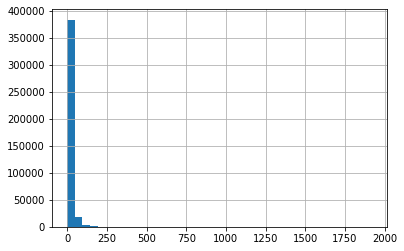

In [ ]:
data_c['CallTime'].hist(bins = 40)

In [ ]:
data_c.loc[data_c['CallTime'] > 240, 'CallTime'].count(), data_c['CallTime'].median()

(325, 5.383333333333333)

In [ ]:
data_c.loc[data_c['CallTime'] > 240, 'CallTime'] = data_c['CallTime'].median()
# Отбросил неправдоподобно большое время звонка (больше двух часов)

In [ ]:
data_c['Date'] = data_c['Date'].apply(lambda x: x.replace('00,000','00'))
data_c['date'] = pd.to_datetime(data_c['Date'], format='%Y-%m-%d %H:%M:%S')
df_c_t = data_c.groupby('id')['date'].max()-data_c.groupby('id')['date'].min()
oneday = pd.Timedelta(days=1)
df_c_t = df_c_t / oneday
df_c_t
#Перевёл даты в datetime, нашёл промежуток времени для каждого пользователя

id
ОРГ1-00004    352.0
ОРГ1-00005    359.0
ОРГ1-00028    353.0
ОРГ1-00030    353.0
ОРГ1-00044    358.0
              ...  
ОРГ2-05629     74.0
ОРГ2-05862    113.0
ОРГ2-05932     79.0
ОРГ2-06006      0.0
ОРГ2-06638    241.0
Name: date, Length: 1071, dtype: float64

In [ ]:
df_c_ct = data_c.groupby('id')['CallTime'].mean()
df_c_nc = data_c.groupby('id')['NumberOfCalls'].mean()
df_c_activ = data_c[data_c['InOut'] == 'FromUser'].groupby('id')['CallTime'].mean() /data_c.groupby('id')['CallTime'].mean()
df_c_nc_w = data_c[data_c['Вид учета времени'] == 'Выходные дни'].groupby('id')['NumberOfCalls'].mean()
df_c_ct_w = data_c[data_c['Вид учета времени'] == 'Выходные дни'].groupby('id')['CallTime'].mean()
# Сгруппировал по абонентам, посчитал среднее для всего времени и выходных, количество звонков и общ время звонка

In [ ]:
#df_c_nc = data_c[(data_c['Вид учета времени'] == 'Будни') & (data_c['InOut'] == 'FromUser')].groupby('id')['NumberOfCalls'].mean()
#df_c_nc_w = data_c[data_c['Вид учета времени'] == 'Выходные дни'].groupby('id')['NumberOfCalls'].mean()
#df_c_ct_w = data_c[data_c['Вид учета времени'] == 'Выходные дни'].groupby('id')['CallTime'].mean()

In [ ]:
data_call_rez = pd.concat([df_c_t,
                           df_c_ct,
                           df_c_nc,
                           df_c_ct_w,
                           df_c_nc_w, 
                           df_c_activ], axis=1, keys=['total_working_time_days',
                                                              'average_call_time',
                                                              'average_number_calls',
                                                              'average_call_time_on_weekends',
                                                              'average_number_calls_on_weekends', 
                                                              'activ_user'])

In [ ]:
data_call_rez.head(3)

,total_working_time_days,average_call_time,average_number_calls,average_call_time_on_weekends,average_number_calls_on_weekends,activ_user
id,,,,,,
ОРГ1-00004,352.0,18.099660,10.491651,10.450000,4.875,1.017227
ОРГ1-00005,359.0,17.947194,3.982935,34.103509,2.000,1.268309
ОРГ1-00028,353.0,7.948673,4.608407,2.395833,1.250,0.933769


In [ ]:
data_call_rez.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1071 entries, ОРГ1-00004 to ОРГ2-06638
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   total_working_time_days           1071 non-null   float64
 1   average_call_time                 1071 non-null   float64
 2   average_number_calls              1071 non-null   float64
 3   average_call_time_on_weekends     514 non-null    float64
 4   average_number_calls_on_weekends  514 non-null    float64
 5   activ_user                        1058 non-null   float64
dtypes: float64(6)
memory usage: 90.9+ KB


In [ ]:
for i in list(data_call_rez.columns):
    data_call_rez.loc[data_call_rez[i].isna(), i] = 0

Удалил дубликаты. Изменил форматы данных. Сгруппировал по пользователям.Нашёл среднее для общего количества звонков и для времени звонков, для общего времени и для выходных. nan отдельно не обрабатывал.

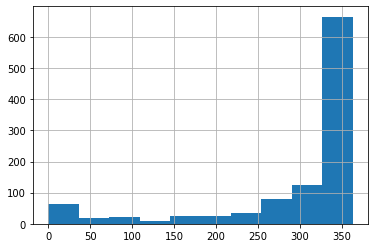

In [ ]:
data_call_rez['total_working_time_days'].hist()

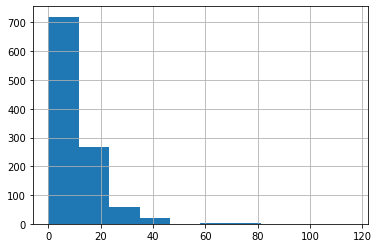

In [ ]:
data_call_rez['average_call_time'].hist()

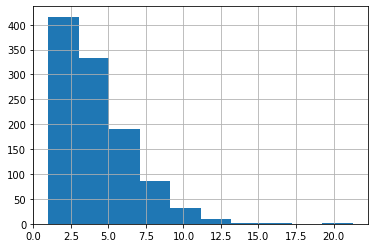

In [ ]:
data_call_rez['average_number_calls'].hist()

## Обработка опозданий

- dateNum: дата;

- maxLogOff: последний выход из сети;

- Нормативное время начала раб.дня: время начала рабочего дня согласно должности и часового пояса;

- Фактич. время начала раб.дня: фактическое время начала рабочего дня

- Время опоздания: длительность опоздания;

- Признак опоздания: опоздание или нет;

- Вых/Будни: выходной или будний день;

- ID: уникальный номер сотрудника.

In [ ]:
data_con = pd.read_csv('ConnectionTime.csv')

In [ ]:
data_con.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [ ]:
data_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB


In [ ]:
sum(data_con.duplicated())

235

In [ ]:
data_con['Признак опоздания'].unique()

array([nan, 'Опоздание'], dtype=object)

In [ ]:
data_con['Время опоздания'].unique()

array([nan, '3,8434999999999997', '2,2224119444444446', ...,
       '6,7784936111111112', '2,5917499999999998', '0,78347027777777778'],
      dtype=object)

Обработка опозданий.

Перевести в нужные форматы. Найти время работы, выделить среднее количество опозданий и среднее время опозданий.

In [ ]:
data_con = data_con.drop_duplicates()
#Удалил дубликаты

In [ ]:
data_con['Время опоздания'] = data_con['Время опоздания'].astype(str)
data_con['Время опоздания'] = data_con['Время опоздания'].apply(lambda x: x.replace(',','.'))
data_con['Время опоздания'] = data_con['Время опоздания'].astype(float)


In [ ]:
data_con['Время опоздания'].sort_values()

158928    0.000005
146336    0.000013
147352    0.000014
136223    0.000021
165461    0.000022
            ...   
127556         NaN
127557         NaN
127558         NaN
127559         NaN
127560         NaN
Name: Время опоздания, Length: 230427, dtype: float64

In [ ]:
#data_con['dateNum'] = data_con['Date'].apply(lambda x: x.replace('00,000','00'))
data_con['dateNum'] = pd.to_datetime(data_con['dateNum'], format='%Y-%m-%d %H:%M:%S,%f')

In [ ]:
df_ct_t = data_con.groupby('id')['dateNum'].max()-data_con.groupby('id')['dateNum'].min()
#oneday = pd.Timedelta(days=1)
df_ct_t = df_ct_t / oneday
df_ct_t

id
ОРГ1-00004    193.0
ОРГ1-00028    192.0
ОРГ1-00030    192.0
ОРГ1-00044    192.0
ОРГ1-00046    193.0
              ...  
ОРГ2-08179      2.0
ОРГ2-08181     10.0
ОРГ2-08203      8.0
ОРГ2-08204      7.0
ОРГ2-08215      3.0
Name: dateNum, Length: 1588, dtype: float64

In [ ]:
df_ct_out_t = data_con[data_con['Вых/Будни'] == 'Будни'].groupby('id')['Время опоздания'].mean()
df_ct_out_c = data_con[data_con['Вых/Будни'] == 'Будни'].groupby('id')['Время опоздания'].count()

In [ ]:
data_con_rez = pd.concat([df_ct_t,
                           df_ct_out_t,
                           df_ct_out_c / (df_ct_t+1)], axis=1, keys=['total_working_time_days_2',
                                                              'average_time_of_lateness',
                                                              'average_number_of_delays'])

In [ ]:
data_con_rez.head(3)

,total_working_time_days_2,average_time_of_lateness,average_number_of_delays
id,,,
ОРГ1-00004,193.0,2.789025,1.350515
ОРГ1-00028,192.0,1.841427,0.264249
ОРГ1-00030,192.0,1.708453,0.678756


In [ ]:
data_con_rez.loc[data_con_rez['average_number_of_delays'].isna(), 'average_number_of_delays'] = 0
data_con_rez.loc[data_con_rez['average_time_of_lateness'].isna(), 'average_time_of_lateness'] = 0
# Заменил пустые значения нулями

Перевести в нужные форматы. Найти время работы, выделить среднее количество опозданий и среднее время опозданий.

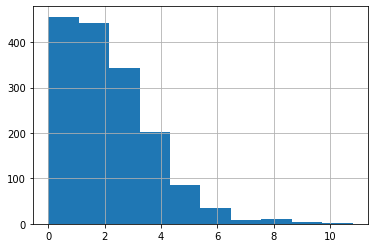

In [ ]:
data_con_rez['average_time_of_lateness'].hist()

<AxesSubplot:>

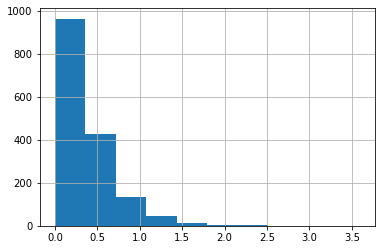

In [ ]:
data_con_rez['average_number_of_delays'].hist()

## Обработка исполнения задач

- Статус по просрочке: без нарушения срока или с нарушением;
- Срок плановый: плановая дата завершения;
- Просрочено, дней: на сколько дней просрочено завершение задания;
- Длительность просрочки: без нарушения срока, более 30 дней, менее 30 дней, менее 7 дней;
- Вид документа: виды документа, связанного с заданием (СЗ, договор и т.п.);
- Дата старта задания;
- Дата завершения задания плановая;
- Дата завершения задания фактическая;
- Состояние задания:
- завершено – завершенное задание,
- на приёмке, на проверке – завершенное, но еще не принятое контролёром задание,
- делегировано – передано другому сотруднику,
- все остальные состояния означают, что задание не завершено.
- ID: уникальный номер сотрудника.

In [ ]:
data_ta = pd.read_csv('Tasks.csv')

In [ ]:
data_ta.head(3)

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588


In [ ]:
data_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536660 entries, 0 to 536659
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Статус по просрочке                  536660 non-null  object
 1   Срок плановый                        15821 non-null   object
 2   Просрочено, дней                     536660 non-null  int64 
 3   ДлительностьПросрочки                536660 non-null  object
 4   ID задачи                            536660 non-null  object
 5   Вид документа                        533143 non-null  object
 6   Дата старта задания                  536660 non-null  object
 7   Дата завершения задания плановая     274057 non-null  object
 8   Дата завершения задания фактическая  520683 non-null  object
 9   Состояние задания                    536660 non-null  object
 10  id                                   536660 non-null  object
dtypes: int64(1), object(10)
me

In [ ]:
sum(data_ta.duplicated())         

0

Обработка задач

Выделить вид документа. Создать сводную таблицу, для каждого пользователя найти среднее количество задач по каждому типу в день, потом найти для кадого пользователя среднюю просрочку по каждой задаче

In [ ]:
data_ta['ДлительностьПросрочки'].unique()

array(['без нарушения срока', 'до 7 дней', 'более 30 дней', 'до 30 дней'],
      dtype=object)

In [ ]:
data_ta['Вид документа'].unique()

array(['Служебная записка', 'Исходящий', 'Входящий',
       'Дополнительное соглашение', 'Договор', 'Внутренний документ',
       'Акт', 'Приказ', nan, 'Файл', 'Распоряжение', 'Протокол',
       'Запрос на внесение изменений', 'Отчет по ВА', 'Исходящий РМЗ',
       'Внутренний документ для БП синхронизация 1С'], dtype=object)

In [ ]:
data_ta.loc[data_ta['Вид документа'].isna(), 'Вид документа'] = 'not'

In [ ]:
data_ta['Статус по просрочке'].unique()

array(['Без нарушения срока', 'С нарушением срока'], dtype=object)

In [ ]:
dadta_ta_tim = data_ta.groupby('id')['Просрочено, дней'].mean()
dadta_ta_sum = data_ta.groupby('id')['ID задачи'].count()

In [ ]:
data_ta['Дата старта задания'] = pd.to_datetime(data_ta['Дата старта задания'], format='%Y-%m-%d %H:%M:%S,%f')

In [ ]:
data_ta_o_t = data_ta.groupby('id')['Дата старта задания'].max()-data_ta.groupby('id')['Дата старта задания'].min()
data_ta_o_t = (data_ta_o_t / oneday) + 1

In [ ]:
data_tasks_rez = pd.concat([data_ta_o_t, dadta_ta_tim, dadta_ta_sum / data_ta_o_t], axis=1)

In [ ]:
#dadta_ta_gr_count = data_ta.pivot_table(index = 'id',
#                                        columns = 'Вид документа', values = 'Просрочено, дней',
#                                        aggfunc = 'count', fill_value = 0) 

#dadta_ta_sum = dadta_ta_sum / data_ta.groupby('id')['Просрочено, дней'].count()

#for i in range(16):
#    dadta_ta_gr_count.iloc[:,i] = dadta_ta_gr_count.iloc[:,i] / data_ta_t

#data_tasks_rez = pd.concat([dadta_ta_sum, dadta_ta_gr_count], axis=1)

# Старый вариант (отказался по причине корреляций в финальной таблице)

In [ ]:
data_tasks_rez.head()

,Дата старта задания,"Просрочено, дней",0
id,,,
ОРГ1-00004,375.0,7.728621,3.056000
ОРГ1-00005,703.0,0.667418,3.156472
ОРГ1-00028,480.0,0.209016,0.508333
ОРГ1-00030,343.0,0.472222,0.104956
ОРГ1-00044,539.0,5.566879,0.582560


In [ ]:
#data_tasks_rez.columns = ['delay_on_task', 'not', 'act', 'document', 'document_1C', 'incoming', 'contract',
#                                 'supp_agreement', 'request', 'outgoing', 'outgoing_rmz', 'report',
#                                 'order', 'protocol', 'order_2', 'memo', 'file']

In [ ]:
data_tasks_rez.columns = ['total_working_time_days_3', 'average_delay', 'average_number_of_tasks']

In [ ]:
data_tasks_rez.head(3)

,total_working_time_days_3,average_delay,average_number_of_tasks
id,,,
ОРГ1-00004,375.0,7.728621,3.056000
ОРГ1-00005,703.0,0.667418,3.156472
ОРГ1-00028,480.0,0.209016,0.508333


In [ ]:
data_tasks_rez.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1272 entries, ОРГ1-00004 to ОРГ2-06373
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_working_time_days_3  1272 non-null   float64
 1   average_delay              1272 non-null   float64
 2   average_number_of_tasks    1272 non-null   float64
dtypes: float64(3)
memory usage: 39.8+ KB


## Обработка уровня образования

- Табельный номер руководителя;

- Табельный номер сотрудника;

- ID: уникальный номер сотрудника.

- Специальность: название специальности.

In [ ]:
data_ed = pd.read_csv('Education.csv')

In [ ]:
data_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609 entries, 0 to 5608
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Табельный номер руководителя  3380 non-null   object
 1   id                            5609 non-null   object
 2   Вид образования               5510 non-null   object
 3   Специальность                 4852 non-null   object
dtypes: object(4)
memory usage: 175.4+ KB


In [ ]:
data_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [ ]:
sum(data_ed.duplicated())

100

In [ ]:
data_ed['Вид образования'].unique()

array(['Высшее образование - бакалавриат',
       'Среднее профессиональное образование', 'Высшее образование',
       'Повышение квалификации', nan, 'Переподготовка',
       'Высшее образование - специалитет, магистратура',
       'Начальное профессиональное образование', 'Аспирантура',
       'Среднее общее образование', 'Среднее (полное) общее образование',
       'Начальное общее образование', 'Неполное высшее образование',
       'Основное общее образование', 'Профессиональное обучение',
       'Послевузовское образование',
       'Дополнительное профессиональное образование'], dtype=object)

In [ ]:
data_ed['Специальность'].unique()

array(['Юриспруденция', 'Финансы', 'Бакалавр технических наук', ...,
       'Дефектоскопист по радиационному контролю',
       'Машинист передвижного электросварочного агрегата с двигателем внутненнего сгорания',
       'Бомпьютерная графика'], dtype=object)

Необходимо объединить общие типы образования, удалить дубликаты.
С учётом того что типов образования много, при этом некоторые люди имеют несколько образований, конкретику можно откинуть. Для упрощения сгруппирую по пользователям и просто посчитаю количество типов образований для каждого.

In [ ]:
data_ed = data_ed.drop_duplicates() 

In [ ]:
data_ed['Вид образования'].value_counts()

Высшее образование                                1437
Среднее профессиональное образование              1009
Среднее общее образование                          620
Начальное профессиональное образование             572
Профессиональное обучение                          497
Высшее образование - бакалавриат                   365
Высшее образование - специалитет, магистратура     327
Повышение квалификации                             297
Среднее (полное) общее образование                 111
Основное общее образование                          66
Переподготовка                                      52
Дополнительное профессиональное образование         23
Неполное высшее образование                         21
Аспирантура                                          6
Начальное общее образование                          6
Послевузовское образование                           2
Name: Вид образования, dtype: int64

In [ ]:
data_ed.loc[data_ed['Вид образования'] == 'Среднее профессиональное образование', 'Вид образования'] = 'Начальное профессиональное образование'
data_ed.loc[data_ed['Вид образования'] == 'Среднее (полное) общее образование', 'Вид образования'] = 'Среднее общее образование'
data_ed.loc[data_ed['Вид образования'] == 'Основное общее образование', 'Вид образования'] = 'Среднее общее образование'

In [ ]:
#data_ed['Вид образования'] = data_ed['Вид образования'].astype('category')
#data_ed_rez = pd.DataFrame([data_ed['Вид образования'].cat.codes.values], index=[data_ed['id'].values], columns='education')

In [ ]:
#data_ed_rez = data_ed['Вид образования'].cat.codes

In [ ]:
#data_ed_rez.index = data_ed['id'].values
#data_ed_rez.columns = 'education'

In [ ]:
#data_ed_rez

In [ ]:
data_ed_rez = pd.DataFrame()
data_ed_rez['num_ed'] = data_ed.groupby('id')['Вид образования'].count()
data_ed_rez['su_ed'] = data_ed.groupby('id')['Вид образования'].sum()

In [ ]:
data_ed_rez.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4788 entries, ОРГ1-00001 to ОРГ2-09286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   num_ed   4788 non-null   int64 
 1   su_ed    4788 non-null   object
 2   su_ed_r  4788 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 278.7+ KB


In [ ]:
data_ed_rez.loc[data_ed_rez['num_ed'] == 0, 'su_ed'] = "Не указано"

In [ ]:
data_ed_rez.loc[data_ed_rez['su_ed'].str.contains('ысшее'), 'su_ed_r'] = 1

In [ ]:
data_ed_rez.loc[data_ed_rez['su_ed'].str.contains('спирантур'), 'su_ed_r'] = 2
data_ed_rez.loc[data_ed_rez['su_ed'].str.contains('ослевуз'), 'su_ed_r'] = 2
data_ed_rez.loc[data_ed_rez['su_ed'].str.contains('овышени'), 'su_ed_r'] = 2

In [ ]:
data_ed_rez.drop(columns = 'su_ed', inplace=True)

## Появление на рабочем месте


- Дата: дата входа/выхода в офис;

- Приход.1: первый вход;

- Уход.1: последний выход:

- Длительность общая: длительность пребывания в офисе;

- Длительность раб.дня без обеда: длительность пребывания в офисе без обеда;

- Вых/Будни: выходной или будний день:

- ID: уникальный номер сотрудника.

In [ ]:
data_sk = pd.read_csv('SKUD.csv')

In [ ]:
data_sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22580 entries, 0 to 22579
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Дата                            22580 non-null  object
 1   Приход.1                        22580 non-null  object
 2   Уход.1                          22580 non-null  object
 3   Длительность общая              22580 non-null  object
 4   Длительность раб.дня без обеда  22580 non-null  object
 5   Вых/Будни                       22580 non-null  object
 6   id                              22580 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


In [ ]:
data_sk.head(2)

,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826


In [ ]:
sum(data_sk.duplicated())                

0

Изменю форматы. Сгруппирую по пользователям и найду средюю продолжительность рабочего времени для будней и выходных.

In [ ]:
data_sk['Длительность раб.дня без обеда'] = data_sk['Длительность раб.дня без обеда'].astype(str)
data_sk['Длительность раб.дня без обеда'] = data_sk['Длительность раб.дня без обеда'].apply(lambda x: x.replace(',','.'))
data_sk['Длительность раб.дня без обеда'] = data_sk['Длительность раб.дня без обеда'].astype(float)

In [ ]:
#data_sk[data_sk['Вых/Будни'] == 'Выходные дни'].groupby('id')['Длительность раб.дня без обеда'].mean()
#data_sk[data_sk['Вых/Будни'] == 'Будни'].groupby('id')['Длительность раб.дня без обеда'].mean()

In [ ]:
data_sk_rez = pd.concat([data_sk[data_sk['Вых/Будни'] == 'Будни'].groupby('id')['Длительность раб.дня без обеда'].mean(),
                           data_sk[data_sk['Вых/Будни'] == 'Выходные дни'].groupby('id')['Длительность раб.дня без обеда'].mean()],
                        axis=1, keys=['work_weekdays', 'weekend work'])

In [ ]:
data_sk_rez.head()

,work_weekdays,weekend work
id,,
ОРГ1-00002,9.462169,NaN
ОРГ1-00004,8.416146,NaN
ОРГ1-00005,8.819444,5.610
ОРГ1-00008,5.000000,NaN
ОРГ1-00010,7.859896,0.425


## Время в системе учёта раб времени 1

интервалы времени в сети в системе учета рабочего времени сотрудника за компьютером

- Вых/Будни: выходной или будний день;
- monitorTime: общее время активности пользователя в сети;
- startTime: дата старта активности;
- ID: уникальный номер сотрудника.

In [ ]:
data_tim = pd.read_csv('TimenNetwork.csv')

In [ ]:
data_tim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216110 entries, 0 to 216109
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Вых/Будни     216110 non-null  object
 1   monitor_Time  216110 non-null  int64 
 2   startTime     216110 non-null  object
 3   id            216110 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.6+ MB


In [ ]:
sum(data_tim.duplicated())  

1069

In [ ]:
data_tim['monitor_Time'].unique()

array([  300,   600,   900, ..., 10831, 86122, 57610])

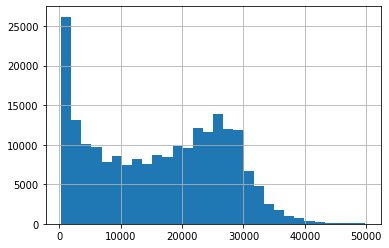

In [ ]:
data_tim['monitor_Time'].hist(bins = 30)

Удалю дубликаты. Сгруппирую по пользователям и найду среднее время работы в выходные и будни.

In [ ]:
data_tim = data_tim.drop_duplicates()

In [ ]:
data_tim.loc[data_tim['monitor_Time']>50000, 'monitor_Time'] = data_tim['monitor_Time'].median()

In [ ]:
data_tim_rez = pd.concat([data_tim[data_tim['Вых/Будни'] == 'Будни'].groupby('id')['monitor_Time'].mean(),
                           data_tim[data_tim['Вых/Будни'] == 'Выходные дни'].groupby('id')['monitor_Time'].mean()],
                        axis=1, keys=['work_weekdays_1', 'weekend work_1'])

## Время в системе учёта раб времени 2

- startTime: дата старта активности;
- activeTime: активное время (пользователь активно пользуется мышью и клавиатурой);
- Вых/Будни: выходной или будний день;
- monitorTime: общее время активности пользователя;
- ID: уникальный номер сотрудника.

In [172]:
data_wd = pd.read_csv('WorkingDay.csv')

ParserError: ignored

In [ ]:
data_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971927 entries, 0 to 1971926
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   startTime    object
 1   activeTime   int64 
 2   Вых/Будни    object
 3   monitorTime  int64 
 4   id           object
dtypes: int64(2), object(3)
memory usage: 52.7+ MB


In [ ]:
data_wd.head(3)

,startTime,activeTime,Вых/Будни,monitorTime,id
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112


In [ ]:
sum(data_wd.duplicated())  

20133

In [ ]:
data_wd['monitorTime'].unique()

array([    2,     4,     3, ..., 69648, 50311, 49726], dtype=int64)

Необходимо удалить дубликаты. После этого сгруппирую по сотрудникам и найду среднее общее время и среднее врямя активности. Потом нужно разделить одно на другое чтобы найти какую часть общего времени занимала активность.

In [ ]:
data_wd_rez = pd.concat([data_wd[data_wd['Вых/Будни'] == 'Будни'].groupby('id')['activeTime'].mean() / data_wd[data_wd['Вых/Будни'] == 'Будни'].groupby('id')['monitorTime'].mean(),
                         data_wd[data_wd['Вых/Будни'] == 'Выходные дни'].groupby('id')['activeTime'].mean() / data_wd[data_wd['Вых/Будни'] == 'Выходные дни'].groupby('id')['monitorTime'].mean()],
                         data_wd[data_wd['Вых/Будни'] == 'Будни'].groupby('id')['activeTime'].mean(),
                         data_wd[data_wd['Вых/Будни'] == 'Выходные дни'].groupby('id')['activeTime'].mean(),
                        axis=1, keys=['work_weekdays_av_2', 'weekend work_av_2', 'work_weekdays', 'weekend work'])

##  Объединение всех подтаблиц по id сотрудников

In [ ]:
data_rez = pd.concat([data_call_rez,
                           data_con_rez,
                           data_tasks_rez,
                           data_ed_rez,
                           data_sk_rez,
                           data_tim_rez,
                           data_wd_rez], axis=1)

In [ ]:
for i in list(data_rez.columns):
    data_rez.loc[data_rez[i].isna(), i] = -1

In [ ]:
data_rez.head()

,total_working_time_days,average_call_time,average_number_calls,average_call_time_on_weekends,average_number_calls_on_weekends,total_working_time_days_2,average_time_of_lateness,average_number_of_delays,total_working_time_days_3,average_delay,average_number_of_tasks,Вид образования,work_weekdays,weekend work,work_weekdays_1,weekend work_1,work_weekdays_av_2,weekend work_av_2
id,,,,,,,,,,,,,,,,,,
ОРГ1-00004,352.0,18.099660,10.491651,10.450000,4.875000,193.0,2.789025,1.350515,375.0,7.728621,3.056000,4.0,8.416146,-1.00,11526.019934,5611.500000,0.310722,0.073084
ОРГ1-00005,359.0,18.618127,3.982935,51.767544,2.000000,-1.0,-1.000000,-1.000000,703.0,0.667418,3.156472,6.0,8.819444,5.61,-1.000000,-1.000000,-1.000000,-1.000000
ОРГ1-00028,353.0,7.948673,4.608407,2.395833,1.250000,192.0,1.841427,0.264249,480.0,0.209016,0.508333,3.0,8.800521,-1.00,20893.580292,9205.000000,0.358959,0.006092
ОРГ1-00030,353.0,7.131913,5.687500,1.000000,1.000000,192.0,1.708453,0.678756,343.0,0.472222,0.104956,2.0,8.462842,-1.00,21788.007299,1700.000000,0.825902,0.966462
ОРГ1-00044,358.0,14.165385,6.203077,6.902778,1.333333,192.0,2.252432,0.072539,539.0,5.566879,0.582560,1.0,9.716667,-1.00,24588.694030,3797.130435,0.688578,0.325765


In [ ]:
data_rez.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5362 entries, ОРГ1-00004 to ОРГ1-03081
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   total_working_time_days           5362 non-null   float64
 1   average_call_time                 5362 non-null   float64
 2   average_number_calls              5362 non-null   float64
 3   average_call_time_on_weekends     5362 non-null   float64
 4   average_number_calls_on_weekends  5362 non-null   float64
 5   total_working_time_days_2         5362 non-null   float64
 6   average_time_of_lateness          5362 non-null   float64
 7   average_number_of_delays          5362 non-null   float64
 8   total_working_time_days_3         5362 non-null   float64
 9   average_delay                     5362 non-null   float64
 10  average_number_of_tasks           5362 non-null   float64
 11  Вид образования                   5362 non-null   float64
 

In [ ]:
data_rez.corr(method= 'pearson')

,total_working_time_days,average_call_time,average_number_calls,average_call_time_on_weekends,average_number_calls_on_weekends,total_working_time_days_2,average_time_of_lateness,average_number_of_delays,total_working_time_days_3,average_delay,average_number_of_tasks,Вид образования,work_weekdays,weekend work,work_weekdays_1,weekend work_1,work_weekdays_av_2,weekend work_av_2
total_working_time_days,1.000000,0.690617,0.892285,0.358414,0.644959,0.659102,0.491913,0.599489,0.640491,0.099033,0.350794,0.224589,0.538448,0.127611,0.696837,0.396700,0.664266,0.597399
average_call_time,0.690617,1.000000,0.731019,0.433313,0.509633,0.467515,0.370267,0.445626,0.512286,0.126889,0.340873,0.117570,0.406170,0.131609,0.525557,0.280280,0.507278,0.450343
average_number_calls,0.892285,0.731019,1.000000,0.358319,0.709476,0.605551,0.458128,0.588077,0.601902,0.108082,0.370482,0.201849,0.505446,0.125305,0.652320,0.377339,0.620935,0.552458
average_call_time_on_weekends,0.358414,0.433313,0.358319,1.000000,0.471606,0.230986,0.198685,0.214607,0.264909,0.045607,0.199472,0.076939,0.241929,0.179971,0.240539,0.166752,0.225872,0.213346
average_number_calls_on_weekends,0.644959,0.509633,0.709476,0.471606,1.000000,0.421502,0.309839,0.390699,0.435638,0.058749,0.286097,0.128002,0.362632,0.117139,0.412328,0.333764,0.403195,0.384193
total_working_time_days_2,0.659102,0.467515,0.605551,0.230986,0.421502,1.000000,0.779706,0.884007,0.682845,0.157869,0.367558,0.234442,0.423120,0.078047,0.747840,0.545384,0.797552,0.756286
average_time_of_lateness,0.491913,0.370267,0.458128,0.198685,0.309839,0.779706,1.000000,0.830857,0.480676,0.133533,0.286462,0.156533,0.270297,0.058968,0.559926,0.442614,0.664288,0.619706
average_number_of_delays,0.599489,0.445626,0.588077,0.214607,0.390699,0.884007,0.830857,1.000000,0.581631,0.158442,0.337421,0.196052,0.323938,0.060635,0.674775,0.486249,0.770548,0.689009
total_working_time_days_3,0.640491,0.512286,0.601902,0.264909,0.435638,0.682845,0.480676,0.581631,1.000000,0.277051,0.420592,0.166550,0.476205,0.094436,0.616596,0.362883,0.628985,0.584516
average_delay,0.099033,0.126889,0.108082,0.045607,0.058749,0.157869,0.133533,0.158442,0.277051,1.000000,0.096225,-0.028305,0.029508,-0.001426,0.112852,0.106765,0.156689,0.138999


In [ ]:
data_rez['total_working_time_mean'] = (data_rez['total_working_time_days'] +
                                       data_rez['total_working_time_days_2'] +
                                       data_rez['total_working_time_days_3']) / 2

In [ ]:
data_rez = data_rez.drop(columns = ['total_working_time_days', 'total_working_time_days_2',
                                    'total_working_time_days_3', 'work_weekdays_av_2'])

In [ ]:
#pred_rf = r_f_c_1.predict(var)
#out_rf = pd.DataFrame(pred_rf, columns=['type'])
#out_rf['id'] = data_test['id']
#out_rf = out_rf.reindex(columns=['id', 'type'])
data_rez.to_csv('data_rez', index=False)

In [ ]:
data_rez = pd.read_csv('data_rez_1.csv')
data_rez = data_rez.set_index('id')

In [ ]:
for i in list(data_rez.columns):
    data_rez.loc[data_rez[i] == -1, i] = 0

In [ ]:
#data_rez['average_number_of_delays_sq'] = data_rez['average_number_of_delays']**2
#data_rez['weekend work_av_2_sq'] = data_rez['weekend work_av_2']**2

In [ ]:
data_rez['work_weekdays_1_sq'] = data_rez['work_weekdays_1']**2
#data_rez['average_call_time_on_weekends_sq'] = data_rez['average_call_time_on_weekends']**2
data_rez['average_time_of_lateness_q'] = data_rez['average_time_of_lateness']**3
#data_rez['work_weekdays_sq'] = data_rez['work_weekdays']**3 

# Подготовка данных для обучения и обучение моделей

In [ ]:
data_targ = pd.read_csv('train_dataset_train.csv')

In [ ]:
data_targ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      550 non-null    object
 1   type    550 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [ ]:
data_targ.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [ ]:
data_targ[data_targ['type'] == 2].count()

id      298
type    298
dtype: int64

In [ ]:
data_test = pd.read_csv('test_dataset_test.csv')
data_targ = pd.read_csv('train_dataset_train.csv')

In [ ]:
data_targ.index = data_targ['id']

In [ ]:
data_targ.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, ОРГ1-02050 to ОРГ2-02694
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      550 non-null    object
 1   type    550 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.9+ KB


In [ ]:
#s = 0
#ou = []
#for i in data_targ.index:
#    if i in data_rez.index:
#        s += 1
#    else:
#        ou.append(i)
#print(s)

In [ ]:
features = data_rez.loc[data_targ.index, :]

In [ ]:
target = data_targ.set_index('id')

In [ ]:
data_test = pd.read_csv('test_dataset_test.csv')
data_targ = pd.read_csv('train_dataset_train.csv')

In [ ]:
target = data_targ.set_index('id')

In [ ]:
features = data_rez.loc[target.index, :]

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, test_size=0.2, random_state=123)

In [ ]:
var = data_rez.loc[data_test['id'], :]

In [ ]:
data_test.count()

id      262
type    262
dtype: int64

In [ ]:
data_targ.count()

id      550
type    550
dtype: int64

## Обучение случайного леса

In [ ]:
r_f_c_1 = RandomForestClassifier(random_state = 123, class_weight='balanced')
r_f_c_1.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', random_state=123)

In [ ]:
r_f_c = RandomForestClassifier(random_state = 123,  class_weight='balanced')
parametrs = { 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' : ['gini', 'entropy'],
              'n_estimators': [40, 60, 100, 150],
              'min_samples_leaf': [2, 3, 4, 5, 6, 7],
              'min_samples_split': [2, 3, 4, 5, 6, 7],
            }
grid_r_f_c = BayesSearchCV(r_f_c, parametrs, cv=5, n_iter = 52, scoring = 'recall_macro')
grid_r_f_c.fit(features_train, target_train)

BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=123),
              n_iter=52, scoring='recall_macro',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                             'min_samples_split': [2, 3, 4, 5, 6, 7],
                             'n_estimators': [40, 60, 100, 150]})

In [ ]:
grid_r_f_c.best_score_

0.4486318876159302

In [ ]:
print('recall_grid', 
      recall_score(target_test, grid_r_f_c.predict(features_test), average='macro'), 
      'f1_grid', 
      f1_score(target_test, grid_r_f_c.predict(features_test), average='macro'))

recall_grid 0.3472549396663622 f1_grid 0.3363370547581074


In [ ]:
#recall_grid 0.23730830248545742 f1_grid 0.20310509554140127

In [ ]:
print('recall_1', 
      recall_score(target_test, r_f_c_1.predict(features_test), average='macro'), 
      'f1_1', 
      f1_score(target_test, r_f_c_1.predict(features_test), average='macro'))

recall_1 0.312390350877193 f1_1 0.3241265651815642


In [ ]:
#recall_1 0.28013076294408923 f1_1 0.26396396396396393

### Проверка метрик

-  Случайный лес без перебора параметров с выделением 30% на тест:
- f1_score (на тесте) - 0.509  (после вылизывания данных - дубликаты, корреляции получил 0,515)
- recall_score (на тесте) - 0.569
- recall на валидации -  0.33

In [ ]:
pred_pr_rf = grid_r_f_c.predict_proba(var)
#out_rf = pd.DataFrame(pred_rf, columns=['type'])
#out_rf['id'] = data_test['id']
#out_rf = out_rf.reindex(columns=['id', 'type'])
#out_rf.to_csv('40_out_rf_gr.csv', index=False)

In [ ]:
#data.loc[:, 'weight'].hist(bins=60, figsize = (10, 6))

## Катбуст

In [ ]:
y_train = np.array(data_targ['type'])
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
params = {'depth': [3, 4, 6, 7, 8],
          'learning_rate' : [0.01, 0.02, 0.03],
         'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
         'iterations': [800, 900, 1000, 1200],
         'bootstrap_type':['No']}
cb_c = cb.CatBoostClassifier(loss_function = 'MultiClass', verbose=False, thread_count = -1, 
                             random_state = 123, class_weights = class_weights)
cb_bayes = BayesSearchCV(cb_c, params, scoring="recall_macro", cv = 3, n_iter = 68)
cb_bayes.fit(features_train, target_train)

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7efe03966a50>,
              n_iter=68, scoring='recall_macro',
              search_spaces={'bootstrap_type': ['No'], 'depth': [3, 4, 6, 7, 8],
                             'iterations': [800, 900, 1000, 1200],
                             'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
                             'learning_rate': [0.01, 0.02, 0.03]})

In [ ]:
#params = {'depth': [3, 4, 6, 7, 8],
#          'learning_rate' : [0.01, 0.02, 0.03],
#         'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
#         'iterations': [800, 900, 1000, 1200],
#         'bootstrap_type':['No']}
#cb_c = cb.CatBoostClassifier(verbose=False, thread_count = -1, 
#                             random_state = 123, early_stopping_rounds = 50)
#cb_bayes = BayesSearchCV(cb_c, params, scoring="recall_macro", cv = 3, n_iter = 58)
#cb_bayes.fit(features_train, target_train, eval_set=(features_test, target_test))
# С детектором переобучения

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f94b3545d50>,
              n_iter=58, scoring='recall_macro',
              search_spaces={'bootstrap_type': ['No'], 'depth': [3, 4, 6, 7, 8],
                             'iterations': [800, 900, 1000, 1200],
                             'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
                             'learning_rate': [0.01, 0.02, 0.03]})

In [ ]:
cb_bayes.best_params_

OrderedDict([('bootstrap_type', 'No'),
             ('depth', 6),
             ('iterations', 1000),
             ('l2_leaf_reg', 2),
             ('learning_rate', 0.03)])

In [ ]:
cb_bayes.best_score_

0.4775389045707817

In [ ]:
print('recall_bayes', 
      recall_score(target_test, cb_bayes.predict(features_test), average='macro'), 
      'f1_bayes', 
      f1_score(target_test, cb_bayes.predict(features_test), average='macro'))

recall_bayes 0.30653574347387147 f1_bayes 0.29017038007863694


In [ ]:
cb_mod = cb.CatBoostClassifier(loss_function = 'MultiClass',
                               verbose=False, thread_count = -1, iterations = 1000,
                               random_state = 123, l2_leaf_reg = 2, learning_rate = 0.03,
                               depth= 6, class_weights = class_weights)
cb_mod.fit(features_train, target_train)

In [ ]:
print('recall_mod', 
      recall_score(target_test, cb_mod.predict(features_test), average='macro'), 
      'f1_mod', 
      f1_score(target_test, cb_mod.predict(features_test), average='macro'))

recall_mod 0.31685976635738666 f1_mod 0.3019946003816971


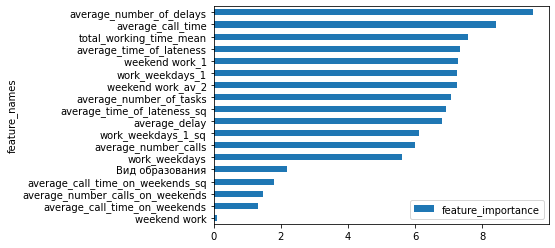

In [ ]:
data = pd.DataFrame({'feature_importance': cb_mod.get_feature_importance(), 
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

## LGBMClassifier

In [ ]:
params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20, 25, 30, 35, 40],
          'learning_rate' : [0.01, 0.05, 0.1, 0.15],
         'lambda_l2': [0, 7, 10, 12, 15, 20, 30, 35],
         'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
          'n_estimators' : [80, 100, 120, 150, 300, 350],
          'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
         'cat_smooth': [1, 3, 5, 8, 10, 13, 15, 20, 35]}

lgb = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_bayes = BayesSearchCV(lgb, params, scoring="recall_macro", cv = 5, n_iter = 64)
lgb_bayes.fit(features_train, target_train)


BayesSearchCV(cv=5,
              estimator=LGBMClassifier(class_weight='balanced',
                                       random_state=123, verbose_eval=False),
              n_iter=64, scoring='recall_macro',
              search_spaces={'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95,
                                                  0.99],
                             'cat_smooth': [1, 3, 5, 8, 10, 13, 15, 20, 35],
                             'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95,
                                                  0.99],
                             'lambda_l2': [0, 7, 10, 12, 15, 20, 30, 35],
                             'learning_rate': [0.01, 0.05, 0.1, 0.15],
                             'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20,
                                           25, 30, 35, 40],
                             'n_estimators': [80, 100, 120, 150, 300, 350]})

In [ ]:
lgb_bayes.best_params_

OrderedDict([('bagging_fraction', 0.6),
             ('cat_smooth', 13),
             ('feature_fraction', 0.95),
             ('lambda_l2', 12),
             ('learning_rate', 0.05),
             ('max_depth', 3),
             ('n_estimators', 100)])

In [ ]:
lgb_bayes.best_score_

0.4655716067523237

In [ ]:
#pred_pr_lgb = lgb_bayes.predict_proba(var)

In [ ]:
#proba = pred_pr_lgb + pred_pr_rf

In [ ]:
pred_lgb = pred_func(proba)
out_lgb = pd.DataFrame(pred_lgb, columns=['type'])
out_lgb['id'] = data_test['id']
out_lgb = out_lgb.reindex(columns=['id', 'type'])
out_lgb.to_csv('10_out_lgb_rf.csv', index=False)

NameError: ignored

In [ ]:
def pred_func(data):
  rez = []
  for i in data:
    rez.append(list(i).index(max(i)))
  return rez

In [ ]:
print('recall_bayes', 
      recall_score(target_test, lgb_bayes.predict(features_test), average='macro'), 
      'f1_bayes', 
      f1_score(target_test, lgb_bayes.predict(features_test), average='macro'))

recall_bayes 0.2815678504467505 f1_bayes 0.25461760461760463


In [ ]:
print('recall_bayes', 
      recall_score(target_test, pred_func(grid_r_f_c.predict_proba(features_test) + lgb_bayes.predict_proba(features_test)), average='macro'), 
      'f1_bayes', 
      f1_score(target_test, pred_func(grid_r_f_c.predict_proba(features_test) + lgb_bayes.predict_proba(features_test)), average='macro'))

recall_bayes 0.3165953559925003 f1_bayes 0.3106909430438842


In [ ]:
pred_lgb = lgb_bayes.predict(var)
out_lgb = pd.DataFrame(pred_lgb, columns=['type'])
out_lgb['id'] = data_test['id']
out_lgb = out_lgb.reindex(columns=['id', 'type'])
out_lgb.to_csv('40_out_lgb_0_2sq.csv', index=False)

##  LogisticRegression

In [ ]:
from sklearn.preprocessing import StandardScaler  

ss = StandardScaler()
X_train_scaled = ss.fit_transform(features_train)
X_test_scaled = ss.transform(features_test)


In [ ]:
model_l_r = LogisticRegression(random_state = 25072022) #, class_weight = 'balanced')
parametrs = { 'C': [1, 2, 3, 4, 5],
              'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
            }
grid_l_r = GridSearchCV(model_l_r, parametrs, scoring = 'recall_macro', cv=3)
grid_l_r.fit(X_train_scaled, target_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=25072022),
             param_grid={'C': [1, 2, 3, 4, 5], 'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'sag']},
             scoring='recall_macro')

In [ ]:
print('recall_bayes', 
      recall_score(target_test, grid_l_r.predict(features_test), average='macro'), 
      'f1_bayes', 
      f1_score(target_test, grid_l_r.predict(features_test), average='macro'))

recall_bayes 0.26229508196721313 f1_bayes 0.05489510489510489


In [ ]:
'roc_auc_ovr', 'f1_macro'

# Создание новых фичей перебором

In [ ]:
data_rez = pd.read_csv('data_rez_1.csv')
data_rez = data_rez.set_index('id')

In [ ]:
data_test = pd.read_csv('test_dataset_test.csv')
data_targ = pd.read_csv('train_dataset_train.csv')

In [ ]:
target = data_targ.set_index('id')

In [ ]:
features = data_rez.loc[target.index, :]

In [ ]:
features_train_1, features_test_1, target_train, target_test = train_test_split(features, 
                                                                              target, test_size=0.2, random_state=123)

In [ ]:
params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20, 25, 30, 35, 40],
          'learning_rate' : [0.01, 0.05, 0.1, 0.15],
         'lambda_l2': [0, 10, 15, 20, 30, 35, 40],
         'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
          'n_estimators' : [80, 100, 120, 150, 300, 400],
          'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
         'cat_smooth': [1, 3, 5, 8, 10, 13, 15, 20, 35]}

#lgb = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
#lgb_bayes = BayesSearchCV(lgb, params, scoring="recall_macro", cv = 5, n_iter = 70)
#lgb_bayes.fit(features_train, target_train)

In [ ]:
ou_3 = []
nu = 0
for i in data_rez.columns:
  features_train = features_train_1.copy()
  features_test = features_test_1.copy()
  features_train['sq'] = features_train[i]**3
  features_test['sq'] = features_test[i]**3
  lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
  lgb_bayes_sel = BayesSearchCV(lgb_sel, params, scoring="recall_macro", cv = 5, n_iter = 46)
  lgb_bayes_sel.fit(features_train, target_train)
  ou_3.append([recall_score(target_test, lgb_bayes_sel.predict(features_test), average='macro'), i])
  print(ou_3[nu])
  nu +=1

[0.3124969953367627, 'average_call_time']
[0.3083986346810249, 'average_number_calls']
[0.3205615114657949, 'average_call_time_on_weekends']
[0.30826642949858185, 'average_number_calls_on_weekends']
[0.34001455973957295, 'average_time_of_lateness']
[0.3164631508100572, 'average_number_of_delays']
[0.3124969953367627, 'average_delay']
[0.3277194777723598, 'average_number_of_tasks']
[0.3205615114657949, 'Вид образования']
[0.3391904235373299, 'work_weekdays']
[0.33578399390139213, 'weekend work']
[0.3320822487929838, 'work_weekdays_1']
[0.3123647901543195, 'weekend work_1']
[0.3165953559925003, 'weekend work_av_2']
[0.3341855130591249, 'total_working_time_mean']


[0.3124969953367627, 'average_call_time']
[0.3083986346810249, 'average_number_calls']
[0.3205615114657949, 'average_call_time_on_weekends']
[0.30826642949858185, 'average_number_calls_on_weekends']
[0.34001455973957295, 'average_time_of_lateness']
[0.3164631508100572, 'average_number_of_delays']
[0.3124969953367627, 'average_delay']
[0.3277194777723598, 'average_number_of_tasks']
[0.3205615114657949, 'Вид образования']
[0.3391904235373299, 'work_weekdays']
[0.33578399390139213, 'weekend work']
[0.3320822487929838, 'work_weekdays_1']
[0.3123647901543195, 'weekend work_1']
[0.3165953559925003, 'weekend work_av_2']
[0.3341855130591249, 'total_working_time_mean']

In [ ]:
sorted(ou)

[[0.284072881111485, 'average_delay'],
 [0.30430027402528725, 'average_time_of_lateness'],
 [0.3044324792077304, 'average_number_calls'],
 [0.3044324792077304, 'average_number_of_delays'],
 [0.30826642949858185, 'average_number_of_tasks'],
 [0.3124969953367627, 'weekend work_av_2'],
 [0.3163309456276141, 'average_number_calls_on_weekends'],
 [0.3205615114657949, 'total_working_time_mean'],
 [0.3205615114657949, 'Вид образования'],
 [0.32465987212153263, 'average_call_time'],
 [0.32875823277727034, 'weekend work'],
 [0.33181783842809753, 'weekend work_1'],
 [0.3319500436105407, 'work_weekdays'],
 [0.3425144395530435, 'average_call_time_on_weekends'],
 [0.34398071521286755, 'work_weekdays_1']]

[[0.284072881111485, 'average_delay'],
 [0.30430027402528725, 'average_time_of_lateness'],
 [0.3044324792077304, 'average_number_calls'],
 [0.3044324792077304, 'average_number_of_delays'],
 [0.30826642949858185, 'average_number_of_tasks'],
 [0.3124969953367627, 'weekend work_av_2'],
 [0.3163309456276141, 'average_number_calls_on_weekends'],
 [0.3205615114657949, 'total_working_time_mean'],
 [0.3205615114657949, 'Вид образования'],
 [0.32465987212153263, 'average_call_time'],
 [0.32875823277727034, 'weekend work'],
 [0.33181783842809753, 'weekend work_1'],
 [0.3319500436105407, 'work_weekdays'],
 [0.3425144395530435, 'average_call_time_on_weekends'],
 [0.34398071521286755, 'work_weekdays_1']]

# Предсказания на валидации и выгрузка результатов

In [ ]:
z = discarding(test_x)

641


In [ ]:
features_cb_out = replacement(test_x)
features_cb_out = new_fit(features_cb_out)
features_cb_out = features_cb_out.drop(columns =  'id')
#Замена  по функции


In [ ]:
features_lg_out = test_x.drop(columns =  'id')
#Вообще без замены

In [ ]:
pred_cb = cb_bayes.predict_proba(features_cb_out)[:,1]
out_cb = pd.DataFrame(pred_cb, columns=['cardio'])
out_cb['id'] = test_x['id']
out_cb = out_cb.reindex(columns=['id', 'cardio'])
out_cb.to_csv('10_out_cb.csv', index=False)
# Предсказания и выгрузка результатов КАТБУСТ

In [ ]:
pred_lg = lgb_bayes.predict_proba(features_lg_out)[:,1]
out_lg = pd.DataFrame(pred_lg, columns=['cardio'])
out_lg['id'] = test_x['id']
out_lg = out_lg.reindex(columns=['id', 'cardio'])
out_lg.to_csv('10_out_lg.csv', index=False)
# Предсказания и выгрузка результатов ЛГБТ

In [ ]:
pred_rf = grid_r_f_c.predict_proba(features_lg_out)[:,1]
out_rf = pd.DataFrame(pred_rf, columns=['cardio'])
out_rf['id'] = test_x['id']
out_rf = out_rf.reindex(columns=['id', 'cardio'])
out_rf.to_csv('10_out_rf.csv', index=False)
# Предсказания и выгрузка результатов случайного леса

In [ ]:
pred = (pred_cb + pred_lg + pred_rf) / 3
out = pd.DataFrame(pred, columns=['cardio'])
out['id'] = test_x['id']
out = out.reindex(columns=['id', 'cardio'])
out.to_csv('20_out_st.csv', index=False)
# Стекинг двух моделей и выгрузка результатов

Полные данные без обработки:
Катбуст - без валидации, лучший результат 0.80335, тестовый результат - 0.80816

ЛГБМ - без валидации, лучший результат 0.803398, тестовый результат - 0.80857

Блендинг, тестовый результат 0.80865

Полные данные с новыми фичами:

Катбуст - без валидации лучший вариант 0.80347, тестовый вариант - 0.80840

ЛГБМ - без валидации лучший вариант  0.80321, тестовый  0.80837

Блендинг, тестовый вариант 0.80865